# Parameters estimation of the Ivanov model
This notebook estimates the parameters $w_{SA}, w_{SS}, w_{PS}$ of the Ivanov model on heart rate signals using neural networks. In particular, the lampe package will be used to realize Bayesian inference.
https://github.com/francois-rozet/lampe

This notebook is greatly inspired from the lampe tutorial https://lampe.readthedocs.io/en/stable/tutorials.html.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd


import FractalModels as fm


%matplotlib inline

import lampe
from lampe.data import JointLoader, H5Dataset
from lampe.diagnostics import expected_coverage_mc
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point, coverage_plot
from lampe.utils import GDStep

import torch
import torch.nn as nn
import torch.optim as optim

import zuko

from itertools import islice
from tqdm import tqdm

## Generate and save data
https://lampe.readthedocs.io/en/stable/tutorials/simulators.html

In [2]:
# Define the prior distribution of the parameters
Lower = torch.zeros(3)
Upper = torch.zeros(3) + 0.1

prior = zuko.distributions.BoxUniform(Lower, Upper)
theta = prior.sample()
theta

tensor([0.0694, 0.0153, 0.0771])

In [3]:
# Simulator for generating data (here: Ivanov model)
def simulator(theta):
    theta_array = theta.numpy()
    
    return fm.IvanovModel(w_SA=theta_array[0], w_SS=theta_array[1], w_PS=theta_array[2], std_eta=0.5*math.sqrt(2))

x = simulator(theta)

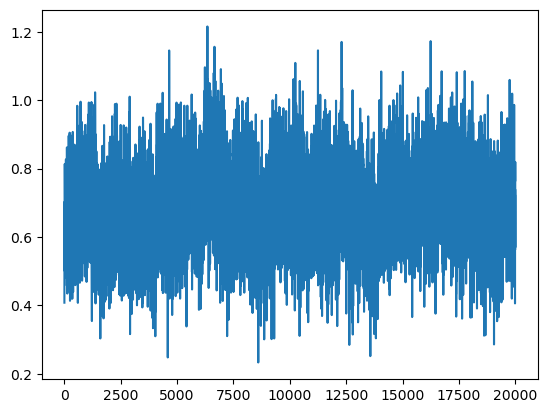

In [4]:
plt.plot(x)

In [ ]:
# Generate the training, validation and testing sets
loader = JointLoader(prior, simulator, batch_size=2**4, vectorized=False)
H5Dataset.store(loader, 'train.h5', size=2**16, overwrite=True)
H5Dataset.store(loader, 'test.h5', size=2**10, overwrite=True)
H5Dataset.store(loader, 'valid.h5', size=2**12, overwrite=True)

## Load data

In [5]:
loader = JointLoader(prior, simulator, batch_size=2**4, vectorized=False)
testset = H5Dataset('/datasets/test.h5')
validset = H5Dataset('/datasets/valid.h5', batch_size=256)
trainset = H5Dataset('/datasets/train.h5', batch_size=256)
len(trainset)

65536

In [6]:
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - Lower) / (Upper - Lower) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (Upper - Lower) + Lower

## Architecture

https://lampe.readthedocs.io/en/stable/tutorials/embedding.html

The time series have a too large number of observations to be directly fed to the lampe neural network. An embedding thus needs to be built. A CNN was chosen in the present case for its ability to distinguish patterns.

In [7]:
def get_embedding():
    nb_channels = 16
    nb_conv_layers = 10
    shrink_every = 3
    final_shape = 20000

    for i in range(nb_conv_layers):
        if i%shrink_every == 0:
            final_shape = math.floor((final_shape - 1)/2 + 1)
        else:
            final_shape = final_shape

    cnn = [nn.Conv1d(in_channels=1, out_channels=nb_channels, kernel_size=1)]

    for i in range(nb_conv_layers):
        if i%shrink_every == 0:
            stride=1
        else:
            stride=2


        cnn.append(nn.Conv1d(in_channels=nb_channels, out_channels=nb_channels, kernel_size=3, padding=1))
        cnn.append(nn.SELU())
        cnn.append(nn.MaxPool1d(3, stride=stride, padding=1))

    cnn.append(nn.Flatten())
    cnn.append(nn.Linear(5008, 512))
    cnn.append(nn.Linear(512, 8))

    return nn.Sequential(*cnn)

In [8]:
class NPEWithEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.npe = NPE(3, 8, build=zuko.flows.NSF, hidden_features=[128] * 3, activation=nn.ELU)
        self.embedding = get_embedding()

    def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        embs = self.embedding(x).squeeze(0)
        #print(y.size())
        x = self.npe(theta, embs)
        #print(x.size())
        return x

    def flow(self, x: torch.Tensor):  # -> Distribution
        embs  = self.embedding(x).squeeze(0)
        y = self.npe.flow(embs)
        return y

## Training 

In [9]:
# Hardware
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


In [11]:
estimator = NPEWithEmbedding().to(device)
loss = NPELoss(estimator)
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)

with tqdm(range(32), unit='epoch') as tq:
    for epoch in tq:
        estimator.train()

        losses = torch.stack([
            step(loss(preprocess(theta).to(device), x.unsqueeze(1).to(device)))
            for theta, x in trainset
        ])

        estimator.eval()

        with torch.no_grad():
            val_losses = torch.stack([
                loss(preprocess(theta).to(device), x.unsqueeze(1).to(device))
                for theta, x in validset
            ])

        tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

100%|██████████| 32/32 [28:22<00:00, 53.20s/epoch, loss=-2.71, val_loss=-2.73]


## Save model

In [31]:
torch.save(estimator.state_dict(), "third.pt")

## Load model

In [173]:
model_test = NPEWithEmbedding()
model_test.load_state_dict(torch.load("third.pt"))

NPEWithEmbedding(
  (npe): NPE(
    (flow): NSF(
      (transforms): ModuleList(
        (0): MaskedAutoregressiveTransform(
          (base): MonotonicRQSTransform(bins=8)
          (order): [0, 1, 2]
          (hyper): MaskedMLP(
            (0): MaskedLinear(in_features=11, out_features=128, bias=True)
            (1): ELU(alpha=1.0)
            (2): MaskedLinear(in_features=128, out_features=128, bias=True)
            (3): ELU(alpha=1.0)
            (4): MaskedLinear(in_features=128, out_features=128, bias=True)
            (5): ELU(alpha=1.0)
            (6): MaskedLinear(in_features=128, out_features=69, bias=True)
          )
        )
        (1): MaskedAutoregressiveTransform(
          (base): MonotonicRQSTransform(bins=8)
          (order): [2, 1, 0]
          (hyper): MaskedMLP(
            (0): MaskedLinear(in_features=11, out_features=128, bias=True)
            (1): ELU(alpha=1.0)
            (2): MaskedLinear(in_features=128, out_features=128, bias=True)
            (3

## Inference
Now that the neural network is trained, we can estimate the parameters of the Ivanov model on a time series.

In [174]:
theta_star, x_star = testset[30]

print(x_star.unsqueeze(0).unsqueeze(0).to(device).shape)

with torch.no_grad():
    samples = estimator.flow(x_star.unsqueeze(0).unsqueeze(0).to(device)).sample((2**16,)).cpu()
    samples = postprocess(samples)

torch.Size([1, 1, 20000])


In [175]:
print(samples.size())

torch.Size([65536, 3])


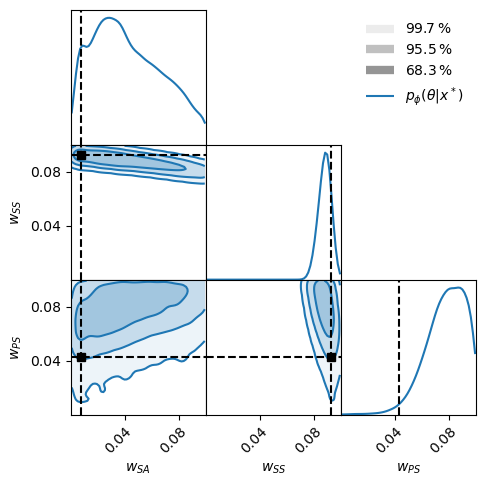

In [176]:
# Plot the estimation
Labels = [r"$w_{SA}$", r"$w_{SS}$", r"$w_{PS}$"]

fig = corner(
    samples.squeeze(1),
    smooth=2,
    domain=(Lower, Upper),
    labels=Labels,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)

### Bayesian inference on heart rate signals

In [28]:
def get_beats(subject, abnormal=False):
    """
    Get the heart rate data for a given subject

    Arguments:
    - subject:  ID of the subject to get the heart rate. Must be of the format
                "group" + "number" + "nn". Where group is n (healthy), c 
                (congestive heart failure) or a (atrial fibrillation) and the
                number is between 1 and 5.
    - abnormal: True to print the proportion of abnormal beats (i.e. noisy 
                data), False otherwise

    Returns:
    - A numpy array with the heart rate (interbeats) signal
    """
    with open('../Heart-rates-disease/' + subject + '.txt') as f:
        lines = f.readlines()

    beats = []
    
    count_abnormal = 0
    count = 0

    for line in lines:
        line = line.split()
        if line[1] != "N":
            count_abnormal += 1
        beats.append(float(line[0]))
        count += 1
    
    if abnormal:
        print("Abnormal beats: ", count_abnormal/count*100, "%")
    return beats

torch.Size([1, 1, 20000])


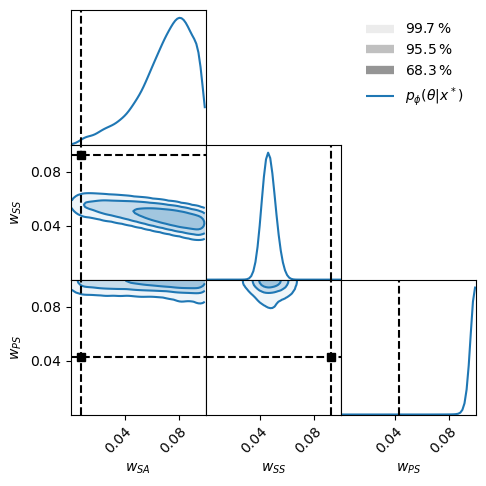

In [177]:
subject = "a5"
data = get_beats(subject + "nn")
x = data[60000:80000] # The heart rate signal must be of size 20.000

x_star = torch.Tensor(x)

print(x_star.unsqueeze(0).unsqueeze(0).to(device).shape)

with torch.no_grad():
    samples = estimator.flow(x_star.unsqueeze(0).unsqueeze(0).to(device)).sample((2**16,)).cpu()
    samples = postprocess(samples)
    
# Plot the estimation
Labels = [r"$w_{SA}$", r"$w_{SS}$", r"$w_{PS}$"]

fig = corner(
    samples.squeeze(1),
    smooth=2,
    domain=(Lower, Upper),
    labels=Labels,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

#### Save results

In [170]:
num = "4"

# Convert the Torch tensor to a NumPy array
numpy_array = samples.numpy()

# Split the NumPy array into three separate arrays along the second axis
numpy_array_1, numpy_array_2, numpy_array_3 = np.split(numpy_array, 3, axis=1)

# Squeeze the arrays to change their shape to (65536,)
numpy_array_1 = np.squeeze(numpy_array_1)
numpy_array_2 = np.squeeze(numpy_array_2)
numpy_array_3 = np.squeeze(numpy_array_3)

# Verify the shapes of the resulting arrays
print(numpy_array_1.shape)  # (65536,)
print(numpy_array_2.shape)  # (65536,)
print(numpy_array_3.shape)  # (65536,)

np.save('SA_' + subject + '_' + num + '.npy', numpy_array_1)
np.save('SS_' + subject + '_' + num + '.npy', numpy_array_2)
np.save('PS_' + subject + '_' + num + '.npy', numpy_array_3)

(65536,)
(65536,)
(65536,)


## Expected coverage
https://lampe.readthedocs.io/en/stable/tutorials/coverage.html

The expected coverage is a way to measure the uncertainty of the model. If the curve is above the diagonal, then the model is undercondident. On the other hand, if the curve is under the diagonal, the model is overconfident.

1024pair [00:33, 30.93pair/s]


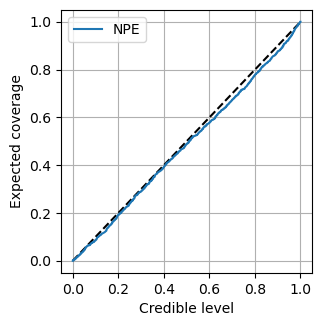

In [178]:
levels, coverages = expected_coverage_mc(
    estimator.flow,
    ((preprocess(theta).to(device), x.unsqueeze(0).unsqueeze(0).to(device)) for theta, x in testset),
)

fig = coverage_plot(levels, coverages, legend='NPE')